In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce
import matplotlib.pyplot as plt


# Nice to have: show all columns in head()
pd.set_option("display.max_columns", 120)

DATA = Path("../data")
PROC = Path("../data/processed"); PROC.mkdir(parents=True, exist_ok=True)

def read_upper(path, dtypes=None):
    df = pd.read_csv(path, low_memory=False, dtype=dtypes or {})
    df.columns = df.columns.str.upper()
    return df

def parse_dt(df, cols=("START","STOP","DATE")):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
    return df


In [2]:
encounters = read_upper(DATA/"encounters.csv")
patients  = read_upper(DATA/"patients.csv")
procedures  = read_upper(DATA/"procedures.csv")

encounters = parse_dt(encounters, cols=("START","STOP"))
patients  = parse_dt(patients,  cols=("START","STOP","DATE"))
procedures  = parse_dt(procedures,  cols=("DATE","START","STOP"))  # some exports have START/STOP here too

print("Patients:", patients.shape)
print("Encounters:", encounters.shape)
print("Observations:", procedures.shape)

procedures.head()

Patients: (22025, 28)
Encounters: (1320125, 15)
Observations: (181974, 10)


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2016-12-27 13:05:42+00:00,2016-12-27 13:20:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-01ba-e037dfac6fcd,SNOMED-CT,430193006,Medication reconciliation (procedure),862.80,NaN,NaN
1,2019-01-08 13:05:42+00:00,2019-01-08 13:20:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-faa0-51a339dc5653,SNOMED-CT,430193006,Medication reconciliation (procedure),232.25,NaN,NaN
2,2020-01-14 13:05:42+00:00,2020-01-14 13:20:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-d184-11e2ad199011,SNOMED-CT,430193006,Medication reconciliation (procedure),218.58,NaN,NaN
3,2021-01-19 13:05:42+00:00,2021-01-19 13:20:42+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-d812-1c6fa1ab6e0a,SNOMED-CT,430193006,Medication reconciliation (procedure),215.70,NaN,NaN
4,2021-01-19 13:05:42+00:00,2021-01-19 13:14:34+00:00,5e944684-ae0a-2387-5a4a-f4d421b0220c,5e944684-ae0a-2387-d812-1c6fa1ab6e0a,SNOMED-CT,103697008,Patient referral for dental care (procedure),431.40,66383009.0,Gingivitis (disorder)


In [3]:
# Number of unique patients
patients['ID'].nunique()

# Number of encounters per patient (first 5)
encounters_per_patient = encounters.groupby('PATIENT').size().head()
print(encounters_per_patient)

# Check a few columns
print(patients.columns)
print(encounters.columns)
print(procedures.columns)

PATIENT
00010e8f-590e-3608-5307-0c075d7b83b6     27
00037657-224c-8a27-8e00-252779d41cc3     36
0004e2d2-969c-2b8e-b5c3-b1cc51eac06a     72
00070edc-4a3d-6dcb-de91-39d828ea23c5    544
00097b68-2bce-3e49-4b50-c28f44deed0b    302
dtype: int64
Index(['ID', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['ID', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')
Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'SYSTEM', 'CODE',
       'DESCRIPTION', 'BASE_COST', 'REASONCODE', 'REASONDESCRIPTION'],
      d

In [4]:
# Filter for inpatient encounters (hospital admissions/discharges):
inpatient = encounters[encounters['ENCOUNTERCLASS'] == 'inpatient'].copy()

In [5]:
# Convert START and STOP times to datetime:
inpatient['START'] = pd.to_datetime(inpatient['START'])
inpatient['STOP']  = pd.to_datetime(inpatient['STOP'])

In [6]:
# Create the “readmission within 30 days” label
inpatient = inpatient.sort_values(['PATIENT', 'START'])
inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
inpatient['READMIT_30D'] = (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
) & (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
)
inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)

In [7]:
# --- feature engineering: merge encounters + patients + observations ---

# 1) Patient demographics → encounters (your current approach)
patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'], errors='coerce', utc=True)
patients['AGE'] = (pd.Timestamp('now', tz='UTC') - patients['BIRTHDATE']).dt.days / 365.25

data = inpatient.merge(
    patients[['ID', 'AGE', 'GENDER', 'RACE', 'ETHNICITY']],
    left_on='PATIENT', right_on='ID', how='left',
    suffixes=('', '_PATIENT')  # avoid name clashes if any
)

In [8]:
# 0) Keep only procedures tied to the inpatient encounters we model
enc_ids = set(inpatient['ID'])
pro = procedures[procedures['ENCOUNTER'].isin(enc_ids)].copy()

# 1) Hygiene: parse DATE if present
if 'DATE' in pro.columns:
    pro['DATE'] = pd.to_datetime(pro['DATE'], errors='coerce', utc=True)

# 2) Build a PROCEDURE category if not available
#    We derive PROC_CATEGORY from DESCRIPTION (lowercased, alnum only).
if 'CATEGORY' in pro.columns:
    pro['PROC_CATEGORY'] = pro['CATEGORY'].astype(str)
else:
    desc = pro.get('DESCRIPTION', pd.Series(index=pro.index, dtype='object')).astype(str)
    pro['PROC_CATEGORY'] = (
        desc.str.lower()
            .str.replace(r'[^a-z0-9]+', ' ', regex=True)
            .str.strip()
            .replace('', 'unknown')
    )

# 3) Limit cardinality: keep Top-K categories, bucket the rest as 'other'
K = 30
topk = pro['PROC_CATEGORY'].value_counts().nlargest(K).index
pro['PROC_CATEGORY_TOPK'] = np.where(pro['PROC_CATEGORY'].isin(topk), pro['PROC_CATEGORY'], 'other')

# 4) Raw category counts per encounter  -> PRO_CATCOUNT_<category>
pro_cat_counts = (
    pd.crosstab(pro['ENCOUNTER'], pro['PROC_CATEGORY_TOPK'])
      .add_prefix('PRO_CATCOUNT_')
)

# 5) Binary “any in category” flags     -> PRO_CATANY_<category>
pro_cat_any = (pro_cat_counts > 0).astype(int)
pro_cat_any.columns = [c.replace('PRO_CATCOUNT_', 'PRO_CATANY_') for c in pro_cat_any.columns]

# 6) Totals and proportions             -> PRO_CATTOTAL, PRO_CATPROP_<category>
pro_totals = pro_cat_counts.sum(axis=1).rename('PRO_CATTOTAL')
with np.errstate(divide='ignore', invalid='ignore'):
    pro_cat_prop = pro_cat_counts.div(pro_totals, axis=0).fillna(0.0)
pro_cat_prop.columns = [c.replace('PRO_CATCOUNT_', 'PRO_CATPROP_') for c in pro_cat_prop.columns]

# 7) Normalize by length of stay (per-day rates) -> PRO_CATPERDAY_<category>
enc_los = (
    inpatient[['ID','START','STOP']]
      .assign(LOS_DAYS=lambda d: ((pd.to_datetime(d['STOP']) - pd.to_datetime(d['START']))
                                  .dt.total_seconds() / 86400.0).clip(lower=1/24))
      .rename(columns={'ID':'ENCOUNTER'})
      .set_index('ENCOUNTER')
)[['LOS_DAYS']]

pro_cat_counts_los = pro_cat_counts.join(enc_los, how='left')
with np.errstate(divide='ignore', invalid='ignore'):
    pro_cat_perday = pro_cat_counts_los.drop(columns=['LOS_DAYS']).div(pro_cat_counts_los['LOS_DAYS'], axis=0).fillna(0.0)
pro_cat_perday.columns = [c.replace('PRO_CATCOUNT_', 'PRO_CATPERDAY_') for c in pro_cat_perday.columns]

# 8) Combine all PROCEDURE-derived features
pro_feats = (
    pro_totals.to_frame()
      .join(pro_cat_counts, how='left')
      .join(pro_cat_any,    how='left')
      .join(pro_cat_prop,   how='left')
      .join(pro_cat_perday, how='left')
      .reset_index()  # ENCOUNTER back to a column
)

# 9) Merge into encounter+patient table
data = data.merge(pro_feats, left_on='ID', right_on='ENCOUNTER', how='left')

# 10) Rebuild X with demographics + PROCEDURE CATEGORY features
base_cols = ['AGE','GENDER','RACE','ETHNICITY']
pro_cols  = [c for c in data.columns if c.startswith(('PRO_CATTOTAL','PRO_CATCOUNT_','PRO_CATANY_','PRO_CATPROP_','PRO_CATPERDAY_'))]

feature_cols = [c for c in base_cols + pro_cols if c in data.columns]
X = data[feature_cols].copy()
y = data['READMIT_30D'].astype(int)

# One-hot encode demographics; numeric PRO_* features pass through
X = pd.get_dummies(X, columns=['GENDER','RACE','ETHNICITY'], drop_first=True)

print("X shape:", X.shape, "| y shape:", y.shape)
print("Sample PROCEDURE CATEGORY cols:", [c for c in X.columns if c.startswith('PRO_CAT')][:10])

X shape: (21789, 9) | y shape: (21789,)
Sample PROCEDURE CATEGORY cols: ['PRO_CATTOTAL']


In [9]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score, confusion_matrix
)
import numpy as np
import pandas as pd

# 1) Grouped split (avoid patient leakage)
groups = data['PATIENT'].astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].astype(int)
y_test  = y.iloc[test_idx].astype(int)

print("Shapes → X_train:", X_train.shape, "X_test:", X_test.shape)
print("Label balance → train:", y_train.value_counts().to_dict(),
      "test:", y_test.value_counts().to_dict())

# 2) Identify column types
#    IMPORTANT: include BOTH numpy bool and pandas nullable 'boolean'
bool_cols = X_train.select_dtypes(include=["bool", "boolean"]).columns.tolist()
num_cols  = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols  = [c for c in num_cols if c not in bool_cols]  # remove bools from numeric
cat_cols  = X_train.select_dtypes(exclude=[np.number, "bool", "boolean"]).columns.tolist()

print(f"[info] numeric={len(num_cols)}, boolean={len(bool_cols)}, categorical={len(cat_cols)}")

# 3) Preprocessor
pre = ColumnTransformer(
    transformers=[
        # Numeric: median impute + scale
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scl", StandardScaler(with_mean=True))
        ]), num_cols),

        # Boolean: CAST → IMPUTE  (cast FIRST so SimpleImputer doesn't see dtype bool)
        ("bool", Pipeline([
            ("tofloat", FunctionTransformer(lambda X: X.astype("float64"), feature_names_out="one-to-one")),
            ("imp", SimpleImputer(strategy="most_frequent")),
            # optional: keep as float (0.0/1.0). If you prefer ints:
            # ("toint", FunctionTransformer(lambda X: X.astype(int), feature_names_out="one-to-one")),
        ]), bool_cols),

        # Categorical: impute most-frequent + one-hot
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

# 4) Pipeline: preprocess -> logistic
pipe = Pipeline(steps=[
    ("pre", pre),
    ("logreg", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    )),
])

# 5) Fit
pipe.fit(X_train, y_train)

# 6) Predict + metrics
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

print("Test prevalence (positive rate):", y_test.mean().round(4))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))
print("PR AUC (average precision):", average_precision_score(y_test, y_prob).round(4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# 7) Coefficients with real, post-transform names
feat_names = pipe.named_steps["pre"].get_feature_names_out().tolist()
coef = pipe.named_steps["logreg"].coef_.ravel()
assert len(feat_names) == coef.size

coef_df = pd.DataFrame({"feature": feat_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["odds_ratio_per_1sd"] = np.exp(coef_df["coef"])  # numeric scaled; bool/OHE are 0/1

# Optional: clean prefixes
coef_df["feature"] = (coef_df["feature"]
                      .str.replace("^num__imp__", "", regex=True)
                      .str.replace("^num__scl__", "", regex=True)
                      .str.replace("^bool__tofloat__", "", regex=True)
                      .str.replace("^bool__imp__", "", regex=True)
                      .str.replace("^cat__imp__", "", regex=True)
                      .str.replace("^cat__ohe__", "", regex=True))

coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

print("\nTop 15 features by |coef| (standardized):")
print(coef_df_sorted.head(15)[["feature", "coef", "odds_ratio_per_1sd"]].to_string(index=False))

# (Optional) show top PROCEDURE-only features
proc_only = coef_df_sorted[coef_df_sorted["feature"].str.contains(r"^PRO_", regex=True)]
if not proc_only.empty:
    print("\nTop 15 PROCEDURE features by |coef|:")
    print(proc_only.head(15)[["feature", "coef", "odds_ratio_per_1sd"]].to_string(index=False))

print(f"\nIntercept (log-odds): {float(pipe.named_steps['logreg'].intercept_):.4f}")

Shapes → X_train: (15706, 9) X_test: (6083, 9)
Label balance → train: {0: 12725, 1: 2981} test: {0: 5223, 1: 860}
[info] numeric=2, boolean=7, categorical=0


C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Test prevalence (positive rate): 0.1414
ROC AUC: 0.6747
PR AUC (average precision): 0.2269

Classification report:
               precision    recall  f1-score   support

           0     0.8918    0.6489    0.7512      5223
           1     0.1967    0.5221    0.2857       860

    accuracy                         0.6309      6083
   macro avg     0.5443    0.5855    0.5185      6083
weighted avg     0.7936    0.6309    0.6854      6083

Confusion matrix:
 [[3389 1834]
 [ 411  449]]

Top 15 features by |coef| (standardized):
                    feature      coef  odds_ratio_per_1sd
          bool__RACE_native -1.693408            0.183892
             bool__GENDER_M  0.735577            2.086686
                   num__AGE  0.719706            2.053830
        bool__RACE_hawaiian -0.372696            0.688875
           bool__RACE_black -0.277020            0.758039
           bool__RACE_white -0.136077            0.872775
bool__ETHNICITY_nonhispanic -0.122566            0.884647
    

C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\AppData\Local\Temp\ipykernel_18324\3380295182.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"\nIntercept (log-odds): {float(pipe.named_steps['logreg'].intercept_):.4f}")


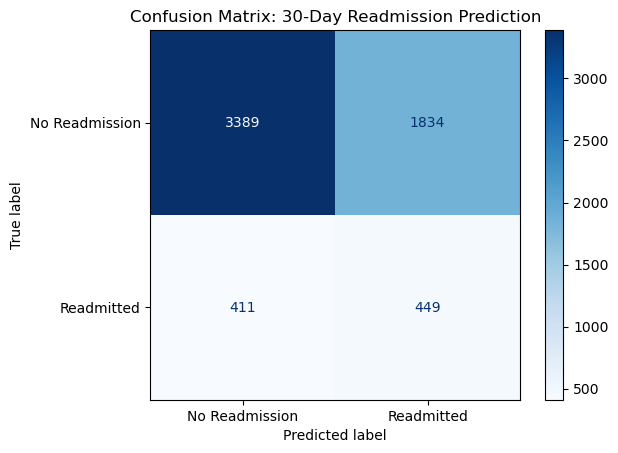

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmitted"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: 30-Day Readmission Prediction")
plt.show()

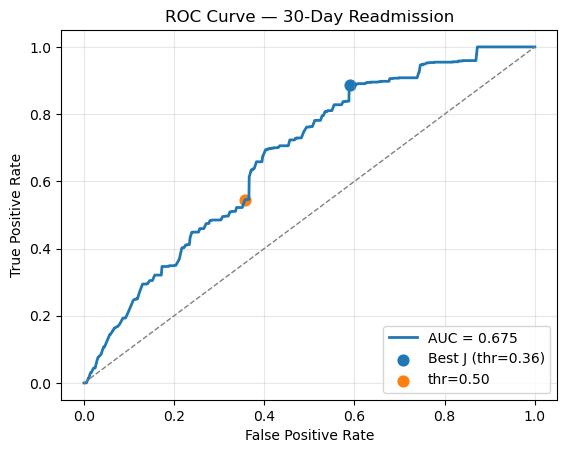

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Make sure we have probabilities
try:
    y_prob  # already computed earlier
except NameError:
    # fall back to the current pipeline 'pipe'
    y_prob = pipe.predict_proba(X_test)[:, 1]

# 1) ROC points + AUC
fpr, tpr, thr = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# 2) Find "best" threshold by Youden's J (tpr - fpr)
j_scores = tpr - fpr
j_idx = np.argmax(j_scores)
best_thr = thr[j_idx]
best_point = (fpr[j_idx], tpr[j_idx])

# 3) Also mark the default 0.5 threshold point
# (find closest threshold to 0.5)
half_idx = np.argmin(np.abs(thr - 0.5))
half_point = (fpr[half_idx], tpr[half_idx])

# 4) Plot ROC
plt.figure()
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray")
plt.scatter(*best_point, s=60, label=f"Best J (thr={best_thr:.2f})")
plt.scatter(*half_point, s=60, label=f"thr=0.50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — 30-Day Readmission")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

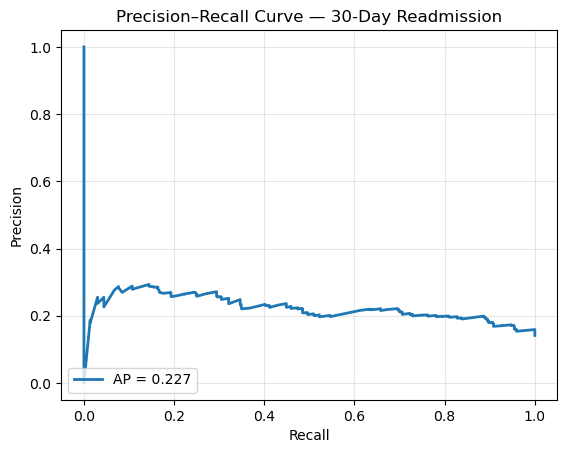

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(rec, prec, linewidth=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — 30-Day Readmission")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

Shapes → X_train: (15706, 9) X_test: (6083, 9)
Label balance → train: {0: 12725, 1: 2981} test: {0: 5223, 1: 860}
[info] numeric=2, boolean=7, categorical=0


C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Vishal Yadav\anaconda3\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['PRO_CATTOTAL']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



Test prevalence (positive rate): 0.1414
ROC AUC: 0.5923
PR  AUC (avg precision): 0.1742

Classification report:
               precision    recall  f1-score   support

           0     0.8619    0.9083    0.8845      5223
           1     0.1727    0.1163    0.1390       860

    accuracy                         0.7963      6083
   macro avg     0.5173    0.5123    0.5117      6083
weighted avg     0.7645    0.7963    0.7791      6083

Confusion matrix:
 [[4744  479]
 [ 760  100]]


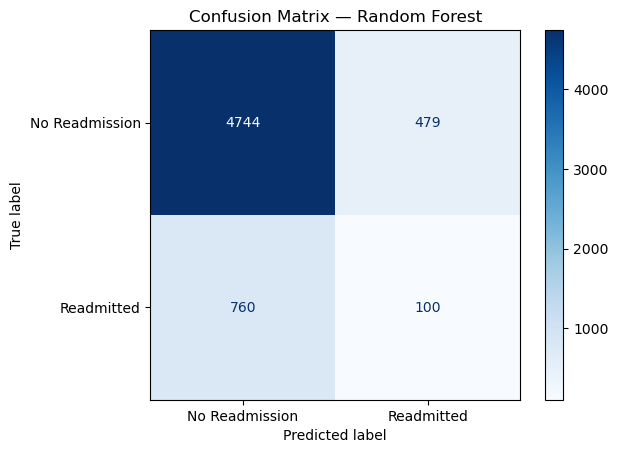

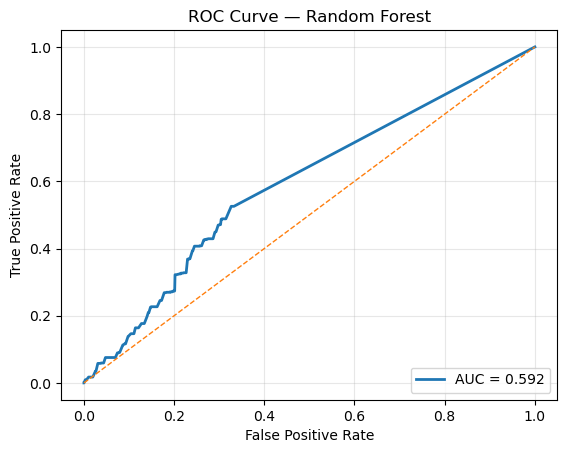

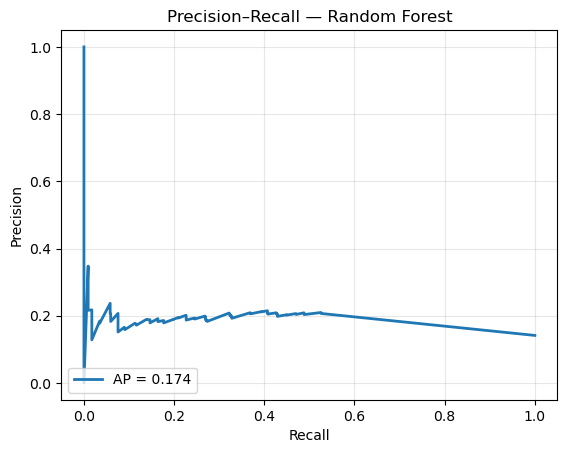


Top 20 features by importance:
                    feature  importance
                        AGE    0.888407
             bool__GENDER_M    0.082578
bool__ETHNICITY_nonhispanic    0.009115
           bool__RACE_white    0.008647
           bool__RACE_black    0.005091
        bool__RACE_hawaiian    0.003077
           bool__RACE_other    0.001909
          bool__RACE_native    0.001177


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)

# --- 1) Group-aware split (avoid patient leakage) ---
groups = data['PATIENT'].astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].copy()
X_test  = X.iloc[test_idx].copy()
y_train = pd.Series(y.iloc[train_idx]).astype(int)
y_test  = pd.Series(y.iloc[test_idx]).astype(int)

print("Shapes → X_train:", X_train.shape, "X_test:", X_test.shape)
print("Label balance → train:", y_train.value_counts().to_dict(),
      "test:", y_test.value_counts().to_dict())

# --- 2) Identify column types (handle both numpy bool and pandas nullable boolean) ---
bool_cols = X_train.select_dtypes(include=["bool", "boolean"]).columns.tolist()
num_cols  = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols  = [c for c in num_cols if c not in bool_cols]  # exclude bools from numeric
cat_cols  = X_train.select_dtypes(exclude=[np.number, "bool", "boolean"]).columns.tolist()
print(f"[info] numeric={len(num_cols)}, boolean={len(bool_cols)}, categorical={len(cat_cols)}")

# --- 3) Preprocessor (trees: no scaling needed) ---
pre = ColumnTransformer(
    transformers=[
        # Numeric → median impute
        ("num", SimpleImputer(strategy="median"), num_cols),

        # Boolean → cast to float (0/1) THEN impute most_frequent
        ("bool", Pipeline([
            ("tofloat", FunctionTransformer(lambda A: A.astype("float64"), feature_names_out="one-to-one")),
            ("imp", SimpleImputer(strategy="most_frequent")),
        ]), bool_cols),

        # Categorical → most_frequent impute + OneHot
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

# --- 4) RF pipeline ---
rf_pipe = Pipeline(steps=[
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])

# --- 5) Train ---
rf_pipe.fit(X_train, y_train)

# --- 6) Predict & metrics ---
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

print("\nTest prevalence (positive rate):", y_test.mean().round(4))
print("ROC AUC:", roc_auc_score(y_test, y_prob).round(4))
print("PR  AUC (avg precision):", average_precision_score(y_test, y_prob).round(4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmission", "Readmitted"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Random Forest")
plt.show()

# --- 7) ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest")
plt.legend(loc="lower right"); plt.grid(True, alpha=0.3)
plt.show()

# --- 8) Precision–Recall curve ---
prec, rec, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)
plt.figure()
plt.plot(rec, prec, linewidth=2, label=f"AP = {ap:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — Random Forest")
plt.legend(loc="lower left"); plt.grid(True, alpha=0.3)
plt.show()

# --- 9) Feature importances with REAL post-transform names ---
rf = rf_pipe.named_steps["rf"]
imp = rf.feature_importances_

feat_names = rf_pipe.named_steps["pre"].get_feature_names_out()
assert imp.size == feat_names.size, f"mismatch: {imp.size} importances vs {feat_names.size} names"

imp_df = (
    pd.DataFrame({"feature": feat_names, "importance": imp})
      .sort_values("importance", ascending=False)
)

# (Optional) clean prefixes for readability
imp_df["feature"] = (imp_df["feature"]
                     .str.replace("^num__", "", regex=True)
                     .str.replace("^bool__tofloat__", "", regex=True)
                     .str.replace("^bool__imp__", "", regex=True)
                     .str.replace("^cat__imp__", "", regex=True)
                     .str.replace("^cat__ohe__", "", regex=True))

print("\nTop 20 features by importance:")
print(imp_df.head(20).to_string(index=False))